In [ ]:
# Importar as bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from EDA_v0 import *
from scipy.stats import linregress
import statsmodels.formula.api as smf
from empiricaldist import Pmf
from empiricaldist import Cdf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
%load_ext autoreload
%autoreload 2

## Estrutura dos Datasets

![image.png](attachment:image.png)

### application_{train|test}.csv
- Principal dataframe: Dados estáticos para todas as aplicações. Cada linha representa um empréstimo (loan) na amostra.

---

## Datasets

In [ ]:
# DataFrame
train = pd.read_csv("datasets/application_train.csv", index_col=[0])

In [ ]:
train.shape

(246008, 121)

In [ ]:
# Redução de memória
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train = reduce_mem_usage(train)

Memory usage after optimization is: 74.84 MB
Decreased by 67.3%


### Limpeza - Removendo colunas

In [ ]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
456162,0,Cash loans,F,N,N,0,"112,500.00","700,830.00","22,738.50","585,000.00",Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.02,-8676,-813,"-4,164.00",-1363,NaN,1,1,1,1,0,0,Core staff,1.00,2,2,FRIDAY,17,0,0,0,1,1,0,Trade: type 2,NaN,0.70,0.17,0.06,0.03,0.98,0.67,0.01,0.00,0.10,0.17,0.04,0.00,0.05,0.05,0.00,0.00,0.06,0.03,0.98,0.69,0.01,0.00,0.10,0.17,0.04,0.00,0.06,0.05,0.00,0.00,0.06,0.03,0.98,0.68,0.01,0.00,0.10,0.17,0.04,0.00,0.05,0.05,0.00,0.00,reg oper account,block of flats,0.04,Block,No,0.00,0.00,0.00,0.00,-589.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
134978,0,Cash loans,F,N,N,0,"90,000.00","375,322.50","14,422.50","324,000.00",Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.03,-13583,-223,"-3,554.00",-3287,NaN,1,1,0,1,0,0,High skill tech staff,2.00,2,2,MONDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.54,0.20,0.77,0.02,0.06,0.98,0.73,0.02,0.00,0.10,0.04,0.08,0.01,0.02,0.02,0.00,0.00,0.02,0.06,0.98,0.75,0.02,0.00,0.10,0.04,0.08,0.01,0.02,0.02,0.00,0.00,0.02,0.06,0.98,0.74,0.02,0.00,0.10,0.04,0.08,0.01,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.02,Block,No,0.00,0.00,0.00,0.00,"-1,409.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00
318952,0,Cash loans,M,Y,N,0,"180,000.00","544,491.00","16,047.00","454,500.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-13993,-6202,"-7,972.00",-4175,9.00,1,1,1,1,0,0,Managers,2.00,2,2,THURSDAY,15,0,0,0,0,0,0,Business Entity Type 1,NaN,0.71,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
col_drop = [# Drop
            "CODE_GENDER", #"AMT_CREDIT", "AMT_ANNUITY", # drop na v0
            "FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", 
            # Drop na v0
            "OCCUPATION_TYPE", "CNT_FAM_MEMBERS",
            # Drop
            "REGION_RATING_CLIENT", "WEEKDAY_APPR_PROCESS_START",
            "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION",
            "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION",
            "REG_CITY_NOT_LIVE_CITY", "ORGANIZATION_TYPE",
            # Drop - muito NaN
            "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG",
            "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEVATORS_AVG",
            "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG",
            "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", "LIVINGAREA_AVG",
            "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "APARTMENTS_MODE",
            "BASEMENTAREA_MODE", "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE",
            "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE",
            "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE",
            "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE", "NONLIVINGAPARTMENTS_MODE",
            "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI",
            "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI",
            "ELEVATORS_MEDI", "ENTRANCES_MEDI", "FLOORSMAX_MEDI",
            "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI",
            "LIVINGAREA_MEDI", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI",
            "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE",
            "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE",
            # Drop - pela interpretabilidade
            "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
            "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
            # Drop na v0
            "EXT_SOURCE_1", "EXT_SOURCE_3",
            "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4",
            "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7",
            "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10",
            "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13",
            "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16",
            "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19",
            "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21",
            # Drop na v0
            "AMT_REQ_CREDIT_BUREAU_YEAR"]

### Dataset com colunas dropadas - train_drop

In [ ]:
train_drop = train.drop(col_drop, axis = 1)
train_drop.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
456162,0,Cash loans,N,N,0,"112,500.00","700,830.00","22,738.50","585,000.00",Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.02,-8676,-813,"-4,164.00",-1363,NaN,1,1,2,1,0,0.70,-589.00,0.00,0.00,0.00,0.00,0.00
134978,0,Cash loans,N,N,0,"90,000.00","375,322.50","14,422.50","324,000.00",Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.03,-13583,-223,"-3,554.00",-3287,NaN,1,0,2,0,0,0.20,"-1,409.00",0.00,0.00,0.00,1.00,0.00
318952,0,Cash loans,Y,N,0,"180,000.00","544,491.00","16,047.00","454,500.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-13993,-6202,"-7,972.00",-4175,9.00,1,1,2,0,0,0.71,-675.00,0.00,0.00,0.00,1.00,1.00
361264,0,Cash loans,N,Y,0,"270,000.00","814,041.00","28,971.00","679,500.00",Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.05,-22425,365243,"-11,808.00",-1732,NaN,0,0,1,0,0,0.72,"-1,588.00",0.00,0.00,0.00,0.00,1.00
260639,0,Cash loans,N,Y,0,"144,000.00","675,000.00","21,906.00","675,000.00",Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.03,-18839,-2763,"-5,068.00",-2381,NaN,1,0,2,0,0,0.71,0.00,0.00,0.00,0.00,10.00,0.00


In [ ]:
train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 456162 to 454197
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       246008 non-null  int8   
 1   NAME_CONTRACT_TYPE           246008 non-null  object 
 2   FLAG_OWN_CAR                 246008 non-null  object 
 3   FLAG_OWN_REALTY              246008 non-null  object 
 4   CNT_CHILDREN                 246008 non-null  int8   
 5   AMT_INCOME_TOTAL             246008 non-null  float32
 6   AMT_CREDIT                   246008 non-null  float32
 7   AMT_ANNUITY                  245998 non-null  float32
 8   AMT_GOODS_PRICE              245782 non-null  float32
 9   NAME_TYPE_SUITE              244960 non-null  object 
 10  NAME_INCOME_TYPE             246008 non-null  object 
 11  NAME_EDUCATION_TYPE          246008 non-null  object 
 12  NAME_FAMILY_STATUS           246008 non-null  object 

In [ ]:
# NaN
train_drop.isna().sum()

TARGET                              0
NAME_CONTRACT_TYPE                  0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        10
AMT_GOODS_PRICE                   226
NAME_TYPE_SUITE                  1048
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    162359
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
REGION_RATING_CLIENT_W_CITY         0
REG_CITY_NOT_WORK_CITY              0
LIVE_CITY_NOT_WORK_CITY             0
EXT_SOURCE_2                      544
DAYS_LAST_PH

## Checkpoint dos DataFrames

In [ ]:
# Dataset original
train.info()
print()
# Dataset com colunas dropadas
train_drop.info()
print()
# train_transf é o modelo "clean"
train_transf = preprocessing(train_drop)
train_transf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 456162 to 454197
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(1), int8(37), object(16)
memory usage: 74.8+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 456162 to 454197
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       246008 non-null  int8   
 1   NAME_CONTRACT_TYPE           246008 non-null  object 
 2   FLAG_OWN_CAR                 246008 non-null  object 
 3   FLAG_OWN_REALTY              246008 non-null  object 
 4   CNT_CHILDREN                 246008 non-null  int8   
 5   AMT_INCOME_TOTAL             246008 non-null  float32
 6   AMT_CREDIT                   246008 non-null  float32
 7   AMT_ANNUITY                  245998 non-null  float32
 8   AMT_GOODS_PRICE              245782 non-null  flo

In [ ]:
train_transf.isna().sum()

TARGET                         0
NAME_CONTRACT_TYPE             0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
REGION_RATING_CLIENT_W_CITY    0
REG_CITY_NOT_WORK_CITY         0
EXT_SOURCE_2                   0
PCT_CREDIT                     0
YEARS_BIRTH                    0
YEARS_EMPLOYED                 0
YEARS_REGISTRATION             0
YEARS_ID_PUBLISH               0
OWN_CAR_TRANS                  0
LAST_MONTH_PHONE_CHANGE        0
TOTAL_AMT_REQ_CREDIT_BUREAU    0
CNT_CHILDREN_CAT               0
dtype: int64

In [ ]:
# Checar as features modificadas
train_transf["NAME_TYPE_SUITE"].value_counts(normalize = True)
#- NAME_CONTRACT_TYPE
#- FLAG_OWN_REALTY
#- NAME_TYPE_SUITE
#- NAME_INCOME_TYPE
#- NAME_EDUCATION_TYPE
#- NAME_FAMILY_STATUS
#- NAME_HOUSING_TYPE

Unaccompanied   0.81
Accompanied     0.19
Name: NAME_TYPE_SUITE, dtype: float64

---

In [ ]:
# Para salvar os modelos fitados em arquivo .pkl.xz
import joblib

## Dados limpos - Salvando os dados num pkl - Podemos trabalhar a partir daqui

In [ ]:
# Cópia do Dataset limpo
treino = train_transf.copy()

In [ ]:
# save
joblib.dump(treino, "dados.pkl.xz")

['dados.pkl.xz']

In [ ]:
# load
treino=joblib.load("dados.pkl.xz")

In [ ]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245026 entries, 456162 to 454197
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       245026 non-null  int8    
 1   NAME_CONTRACT_TYPE           245026 non-null  object  
 2   FLAG_OWN_REALTY              245026 non-null  object  
 3   CNT_CHILDREN                 245026 non-null  int8    
 4   AMT_INCOME_TOTAL             245026 non-null  float32 
 5   AMT_CREDIT                   245026 non-null  float32 
 6   AMT_ANNUITY                  245026 non-null  float32 
 7   AMT_GOODS_PRICE              245026 non-null  float32 
 8   NAME_TYPE_SUITE              245026 non-null  object  
 9   NAME_INCOME_TYPE             245026 non-null  object  
 10  NAME_EDUCATION_TYPE          245026 non-null  object  
 11  NAME_FAMILY_STATUS           245026 non-null  object  
 12  NAME_HOUSING_TYPE            245026 non

In [ ]:
treino.isna().sum()

TARGET                         0
NAME_CONTRACT_TYPE             0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
REGION_RATING_CLIENT_W_CITY    0
REG_CITY_NOT_WORK_CITY         0
EXT_SOURCE_2                   0
PCT_CREDIT                     0
YEARS_BIRTH                    0
YEARS_EMPLOYED                 0
YEARS_REGISTRATION             0
YEARS_ID_PUBLISH               0
OWN_CAR_TRANS                  0
LAST_MONTH_PHONE_CHANGE        0
TOTAL_AMT_REQ_CREDIT_BUREAU    0
CNT_CHILDREN_CAT               0
dtype: int64


-----

## Machine Learning

In [ ]:
# Separando features de target
X = treino.drop(columns = ["TARGET"])
y = treino["TARGET"]

In [ ]:
# Separando os dados de treino e teste - Neste caso, estamos usando somente o dataset de train, pq não tem target no data set de teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
# Bibliotecas para serem usadas - estimadores, tratamentos de dados

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as pp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost

In [ ]:
# Separar categorical e numerical
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes(exclude = 'number').columns

## Logistic Regression

In [ ]:
# pipe alternativo artesanal
cat_pipe_ohe = pp([
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])
num_pipe = pp([
    ('scaler', StandardScaler())    
])

# Para termos no modelo tanto as variáveis categóricas quanto as numéricas
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# Criando pipeline
pipe = pp([
    #('over', SMOTENC(random_state=42, categorical_features=np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols]))),
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator = LogisticRegression(random_state=42), n_features_to_select = 0.5)),
    ('model', LogisticRegression(random_state = 42))
])

parameters = {"rfe__n_features_to_select" : [0.5, 0.7, 0.9],
              "model__C" : [0.5, 1.0, 100],
              "model__penalty" : ["l1", "l2"],
              "model__dual" : [False],
              "model__solver" : ["liblinear"]
             }

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
#grid = GridSearchCV(pipe, param_grid=parameters, cv=kfold, scoring='f1', n_jobs=2, verbose=2)
grid_logistic = RandomizedSearchCV(pipe, param_distributions=parameters, cv=kfold, scoring='f1', verbose=2)

In [ ]:
# SMOTENC - Só é feito no treino
X_res, y_res = SMOTENC(random_state = 42, categorical_features = np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols])).fit_resample(X_train, y_train)

In [ ]:
grid_logistic.fit(X_res, y_res)

In [ ]:
# save logistic fit
joblib.dump(grid_logistic, "logisticV0.pkl.xz")

['logisticV0.pkl.xz']

In [ ]:
# load
grid_logistic=joblib.load("logisticV0.pkl.xz")

In [ ]:
grid_logistic.best_params_

{'rfe__n_features_to_select': 0.9,
 'model__solver': 'liblinear',
 'model__penalty': 'l1',
 'model__dual': False,
 'model__C': 1.0}

In [ ]:
print(f"Selecionadas {sum(grid_logistic.best_estimator_['rfe'].support_)} features de um total de {len(grid_logistic.best_estimator_['rfe'].support_)}")

Selecionadas 30 features de um total de 34


In [ ]:
grid_logistic.best_estimator_['rfe'].support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True])

In [ ]:
best_model = grid_logistic.best_estimator_

In [ ]:
# Analisar o modelo
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OWN_CAR_TRANS...
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'PCT_CREDIT', 'YEARS_BIRTH',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'LAST_MONTH_PHONE_CHANGE', 'CNT_CHILDREN_CAT'],
      dtype='object'))])),
          

In [ ]:
# Output do OneHotEncoder
cat_features

array(['NAME_CONTRACT_TYPE_Revolving loans', 'FLAG_OWN_REALTY_Y',
       'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Other',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Other',
       'NAME_FAMILY_STATUS_Not married', 'NAME_HOUSING_TYPE_Owner',
       'OWN_CAR_TRANS_1', 'OWN_CAR_TRANS_2', 'OWN_CAR_TRANS_3',
       'OWN_CAR_TRANS_4', 'TOTAL_AMT_REQ_CREDIT_BUREAU_1',
       'TOTAL_AMT_REQ_CREDIT_BUREAU_2'], dtype=object)

In [ ]:
# Concatenar todas as features preprocessamento
features_names = list(cat_features) + list(num_cols)

In [ ]:
# Colunas selecionadas com máscara
selected_cols = pd.Series(features_names)[grid_logistic.best_estimator_['rfe'].support_]
selected_cols

0     NAME_CONTRACT_TYPE_Revolving loans
1                      FLAG_OWN_REALTY_Y
2          NAME_TYPE_SUITE_Unaccompanied
3                 NAME_INCOME_TYPE_Other
4             NAME_INCOME_TYPE_Pensioner
5         NAME_INCOME_TYPE_State servant
6               NAME_INCOME_TYPE_Working
7              NAME_EDUCATION_TYPE_Other
8         NAME_FAMILY_STATUS_Not married
9                NAME_HOUSING_TYPE_Owner
10                       OWN_CAR_TRANS_1
11                       OWN_CAR_TRANS_2
12                       OWN_CAR_TRANS_3
13                       OWN_CAR_TRANS_4
14         TOTAL_AMT_REQ_CREDIT_BUREAU_1
15         TOTAL_AMT_REQ_CREDIT_BUREAU_2
16                          CNT_CHILDREN
17                      AMT_INCOME_TOTAL
18                            AMT_CREDIT
20                       AMT_GOODS_PRICE
21            REGION_POPULATION_RELATIVE
22                        FLAG_EMP_PHONE
23                       FLAG_WORK_PHONE
24           REGION_RATING_CLIENT_W_CITY
25              

### Métricas de classificação em Logistic Regression


Métricas de avaliação de treino:


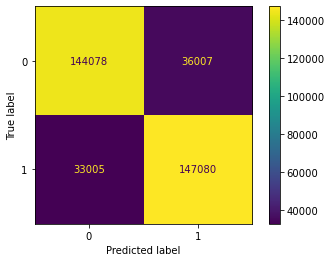

              precision    recall  f1-score   support

           0       0.81      0.80      0.81    180085
           1       0.80      0.82      0.81    180085

    accuracy                           0.81    360170
   macro avg       0.81      0.81      0.81    360170
weighted avg       0.81      0.81      0.81    360170


Métricas de avaliação de teste:


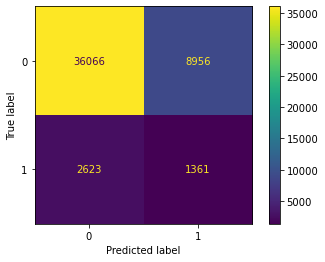

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     45022
           1       0.13      0.34      0.19      3984

    accuracy                           0.76     49006
   macro avg       0.53      0.57      0.53     49006
weighted avg       0.87      0.76      0.81     49006

F1-score weighted: 80.71


0.8071012962732751

In [ ]:
metricas_classificacao(best_model, X_res, X_test, y_res, y_test)

----

## XGBoost

In [ ]:
# Criando pipeline das variáveis categóricas
cat_pipe_ohe = pp([
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])
num_pipe = pp([
    ('scaler', StandardScaler())    
])

# Para termos no modelo tanto as variáveis categóricas quanto as numéricas
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# Criando pipeline
pipe = pp([
    #('over', SMOTENC(random_state=42, categorical_features=np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols]))),
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator = LogisticRegression(random_state=42), n_features_to_select = 0.5)),
    ('model', xgboost.XGBClassifier(random_state = 42))
])

parameters = {"rfe__n_features_to_select" : [0.5, 0.7, 0.9],
              "model__booster": ["gbtree"],
              "model__max_depth": np.arange(4, 21, 3),
              "model__gamma": [0.5, 5],
              "model__eta": [0.01, 0.05, 0.1],
              "model__alpha": [20, 50],
              "model__lambda": [0, 1, 5],
              "model__n_estimators": [100, 200]
             }

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
#grid = GridSearchCV(pipe, param_grid=parameters, cv=kfold, scoring='f1', n_jobs=2, verbose=2)
grid_xgb = RandomizedSearchCV(pipe, param_distributions=parameters, cv=kfold, scoring='f1', verbose=2)

In [ ]:
# SMOTENC - Só é feito no treino
X_res, y_res = SMOTENC(random_state = 42, categorical_features = np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols])).fit_resample(X_train, y_train)

In [ ]:
# Usando reshape de SMOTENC
grid_xgb.fit(X_res, y_res)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[23:47:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model__alpha=50, model__booster=gbtree, model__eta=0.01, model__gamma=0.5, model__lambda=5, model__max_depth=4, model__n_estimators=100, rfe__n_features_to_select=0.9; total time=  18.2s
[23:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model__alpha=50, model__booster=gbtree, model__eta=0.01, model__gamma=0.5, model__lambda=5, model__max_depth=4, mo

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE...
                       

In [ ]:
#save
joblib.dump(grid_xgb, "xgbV0.pkl.xz")

['xgbV0.pkl.xz']

In [ ]:
# load
grid_xgb=joblib.load("xgbV0.pkl.xz")

In [ ]:
best_model = grid_xgb.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OWN_CAR_TRANS...
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', lambda=0,
                               learning_rate=0.100000001, max_delta_step=0,
                          

In [ ]:
grid_xgb.best_params_

{'rfe__n_features_to_select': 0.9,
 'model__n_estimators': 100,
 'model__max_depth': 19,
 'model__lambda': 0,
 'model__gamma': 0.5,
 'model__eta': 0.1,
 'model__booster': 'gbtree',
 'model__alpha': 50}

### Métricas de classificação em XGBoost


Métricas de avaliação de treino:


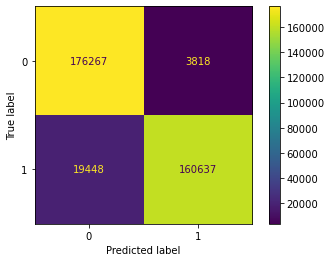

              precision    recall  f1-score   support

           0       0.90      0.98      0.94    180085
           1       0.98      0.89      0.93    180085

    accuracy                           0.94    360170
   macro avg       0.94      0.94      0.94    360170
weighted avg       0.94      0.94      0.94    360170


Métricas de avaliação de teste:


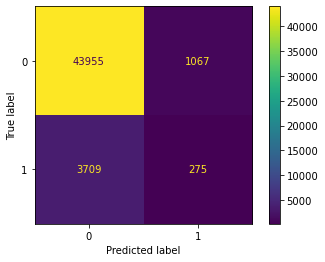

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     45022
           1       0.20      0.07      0.10      3984

    accuracy                           0.90     49006
   macro avg       0.56      0.52      0.53     49006
weighted avg       0.86      0.90      0.88     49006

F1-score weighted: 87.98


0.8797593205893641

In [ ]:
metricas_classificacao(best_model, X_res, X_test, y_res, y_test)

-----

### Random Forest Classifier

In [ ]:
# Criando pipeline das variáveis categóricas
cat_pipe_ohe = pp([
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

#cat_pipe_oe = pp([('oe', OrdinalEncoder())])


num_pipe = pp([
    ('scaler', StandardScaler())    
])

# Para termos no modelo tanto as variáveis categóricas quanto as numéricas
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# Criando pipeline final
pipe = pp([
    #('over', SMOTENC(random_state=42, categorical_features=np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols]))),
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, oob_score=True))
])

parameters = {'model__n_estimators': [100, 200, 250], 'model__max_features': ['auto', 'log2'],  
              'model__max_depth': [4, 8, 20], 'model__criterion': ['gini', 'entropy'], 
              'model__min_samples_split' : [2,4,6]}

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
#grid = GridSearchCV(pipe, param_grid=parameters, cv=kfold, scoring='f1', n_jobs=2, verbose=2)
grid_rf = RandomizedSearchCV(pipe, param_distributions=parameters, cv=kfold, scoring='f1', verbose=2, random_state=42)

In [ ]:
# SMOTENC - Só é feito no treino
X_res, y_res = SMOTENC(random_state = 42, categorical_features = np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols])).fit_resample(X_train, y_train)

In [ ]:
grid_rf.fit(X_res, y_res)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END model__criterion=entropy, model__max_depth=8, model__max_features=auto, model__min_samples_split=4, model__n_estimators=250; total time= 1.2min
[CV] END model__criterion=entropy, model__max_depth=8, model__max_features=auto, model__min_samples_split=4, model__n_estimators=250; total time= 1.2min
[CV] END model__criterion=gini, model__max_depth=4, model__max_features=log2, model__min_samples_split=2, model__n_estimators=200; total time=  36.4s
[CV] END model__criterion=gini, model__max_depth=4, model__max_features=log2, model__min_samples_split=2, model__n_estimators=200; total time=  35.9s
[CV] END model__criterion=gini, model__max_depth=4, model__max_features=auto, model__min_samples_split=4, model__n_estimators=200; total time=  35.9s
[CV] END model__criterion=gini, model__max_depth=4, model__max_features=auto, model__min_samples_split=4, model__n_estimators=200; total time=  35.3s
[CV] END model__criterion=entropy

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE...
       'LAST_MONTH_PHON

In [ ]:
#save
joblib.dump(grid_rf, "rfV0.pkl.xz")

['rfV0.pkl.xz']

In [ ]:
# load
grid_rf=joblib.load("rfV0.pkl.xz")

In [ ]:
best_model = grid_rf.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OWN_CAR_TRANS...
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'PCT_CREDIT', 'YEARS_BIRTH',
       'YEARS_EMPLOYED', 'YE

In [ ]:
 grid_rf.best_params_

{'model__n_estimators': 100,
 'model__min_samples_split': 2,
 'model__max_features': 'log2',
 'model__max_depth': 20,
 'model__criterion': 'gini'}

### Métricas de classificação em RandomForestClassifier


Métricas de avaliação de treino:


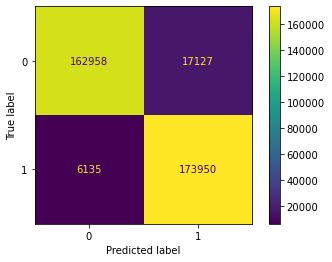

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    180085
           1       0.91      0.97      0.94    180085

    accuracy                           0.94    360170
   macro avg       0.94      0.94      0.94    360170
weighted avg       0.94      0.94      0.94    360170


Métricas de avaliação de teste:


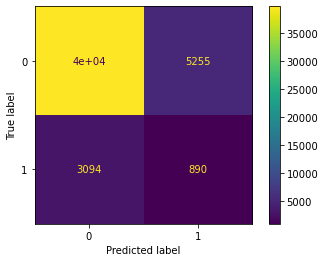

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     45022
           1       0.14      0.22      0.18      3984

    accuracy                           0.83     49006
   macro avg       0.54      0.55      0.54     49006
weighted avg       0.86      0.83      0.85     49006

F1-score weighted: 84.57


0.8457121889635263

In [ ]:
metricas_classificacao(best_model, X_res, X_test, y_res, y_test)

In [ ]:
# Out of the bag score
best_model['model'].oob_score_

0.8829996945886665

-----

## Voting Classifier

#### Defininindo os melhores hiperparâmetros

In [ ]:
# Melhores hiperparâmetros para Regressão Logística 
grid_logistic.best_params_

{'rfe__n_features_to_select': 0.9,
 'model__solver': 'liblinear',
 'model__penalty': 'l1',
 'model__dual': False,
 'model__C': 1.0}

In [ ]:
# Melhores hiperparâmetros para XGBoost
grid_xgb.best_params_

{'rfe__n_features_to_select': 0.9,
 'model__n_estimators': 100,
 'model__max_depth': 19,
 'model__lambda': 0,
 'model__gamma': 0.5,
 'model__eta': 0.1,
 'model__booster': 'gbtree',
 'model__alpha': 50}

In [ ]:
# Melhores hiperparâmetros para Random Forest Classifier 
grid_rf.best_params_

{'model__n_estimators': 100,
 'model__min_samples_split': 2,
 'model__max_features': 'log2',
 'model__max_depth': 20,
 'model__criterion': 'gini'}

#### Instanciando os modelos com os os melhores hiperparâmetros

In [ ]:
# Set seed for reproducibility
SEED=42

# Instantiate lr
lr = LogisticRegression(solver = 'liblinear',
                        penalty= 'l1',
                        dual= False,
                        C = 100,
                        random_state = SEED
                        )

# Instantiate xgb
xgb = xgboost.XGBClassifier(n_estimators = 100,
                            max_depth = 19,
                            reg_lambda = 0,
                            gamma = 0.5,
                            eta = 0.1,
                            booster = 'gbtree',
                            alpha = 50,
                            random_state = SEED
                           )
# Instantiate rf
rf = RandomForestClassifier(n_estimators = 100,
                            min_samples_split= 2,
                            max_features= 'log2',
                            max_depth= 20,
                            criterion= 'gini', 
                            random_state = SEED
                           )

# Define the list classifiers
classifiers = [('Logistic Regression', lr), 
               ('XGBClassifier', xgb), 
               ('Random Forest', rf )]

#### Pipeline para Voting Classifier

In [ ]:
vc = VotingClassifier(estimators=classifiers)     

# Criando pipeline das variáveis categóricas
cat_pipe_ohe = pp([
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

num_pipe = pp([
    ('scaler', StandardScaler())    
])

# Para termos no modelo tanto as variáveis categóricas quanto as numéricas
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# Criando pipeline final
pipe = pp([
    ('preprocessor', preprocessor),
    ('model', vc)
    ])


parameters = {'model__voting': ['soft', 'hard'], 
              'model__weights': [[1,2,2], [1,1,1]],  
              'model__flatten_transform': [True]
              }

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
#grid_vc = GridSearchCV(pipe, param_grid=parameters, cv=kfold, scoring='f1', verbose=2)
grid_vc = RandomizedSearchCV(pipe, param_distributions=parameters, cv=kfold, scoring='f1', verbose=2, random_state=42)

In [ ]:
# SMOTENC - Só é feito no treino
X_res, y_res = SMOTENC(random_state = 42, categorical_features = np.array([i for i,x in enumerate(X_train.columns) if x in cat_cols])).fit_resample(X_train, y_train)

In [ ]:
grid_vc.fit(X_res, y_res)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[23:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model__flatten_transform=True, model__voting=soft, model__weights=[1, 2, 2]; total time= 1.6min
[23:53:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model__flatten_transform=True, model__voting=soft, model__weights=[1, 2, 2]; total time= 1.5min
[23:55:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting 

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE...
                       

In [ ]:
#save
joblib.dump(grid_vc, "vcV0.pkl.xz")

['vcV0.pkl.xz']

In [ ]:
# load
grid_vc=joblib.load("vcV0.pkl.xz")

In [ ]:
best_model = grid_vc.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OWN_CAR_TRANS...
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=1

### Métricas de classificação Voting Classifier


Métricas de avaliação de treino:


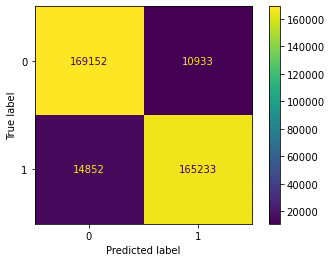

              precision    recall  f1-score   support

           0       0.92      0.94      0.93    180085
           1       0.94      0.92      0.93    180085

    accuracy                           0.93    360170
   macro avg       0.93      0.93      0.93    360170
weighted avg       0.93      0.93      0.93    360170


Métricas de avaliação de teste:


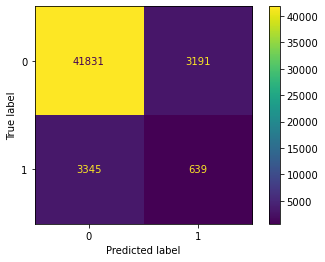

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     45022
           1       0.17      0.16      0.16      3984

    accuracy                           0.87     49006
   macro avg       0.55      0.54      0.55     49006
weighted avg       0.86      0.87      0.87     49006

F1-score weighted: 86.54


0.8654281758550074

In [ ]:
metricas_classificacao(best_model, X_res, X_test, y_res, y_test)

#### Random Forest Classifier é o melhor estimador

----

## SHAP

----
----

## Para o kaggle

In [ ]:
# Baixando o dataset
kaggle_test = pd.read_csv("datasets/application_test.csv", index_col=[0])

In [ ]:
kaggle_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,"135,000.00","568,800.00","20,560.50","450,000.00",Unaccompanied,Working,Higher education,Married,House / apartment,0.02,-19241,-2329,"-5,170.00",-812,NaN,1,1,0,1,0,1,NaN,2.00,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.75,0.79,0.16,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,NaN,block of flats,0.04,"Stone, brick",No,0.00,0.00,0.00,0.00,"-1,740.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
100005,Cash loans,M,N,Y,0,"99,000.00","222,768.00","17,370.00","180,000.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-18064,-4469,"-9,118.00",-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.00,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.56,0.29,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
100013,Cash loans,M,Y,Y,0,"202,500.00","663,264.00","69,777.00","630,000.00",NaN,Working,Higher education,Married,House / apartment,0.02,-20038,-4458,"-2,175.00",-3503,5.00,1,1,0,1,0,0,Drivers,2.00,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.70,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-856.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00

In [ ]:
# Preprocessing function
def preprocessing_kaggle_test(df):
    #>> DROPING COLUMNS
    #===================================================================================================
    col_drop = [# Drop
            "CODE_GENDER", #"AMT_CREDIT", "AMT_ANNUITY", # drop na v0
            "FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", 
            # Drop na v0
            "OCCUPATION_TYPE", "CNT_FAM_MEMBERS",
            # Drop
            "REGION_RATING_CLIENT", "WEEKDAY_APPR_PROCESS_START",
            "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION",
            "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION",
            "REG_CITY_NOT_LIVE_CITY", "ORGANIZATION_TYPE",
            # Drop - muito NaN
            "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG",
            "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEVATORS_AVG",
            "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG",
            "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", "LIVINGAREA_AVG",
            "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "APARTMENTS_MODE",
            "BASEMENTAREA_MODE", "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE",
            "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE",
            "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE",
            "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE", "NONLIVINGAPARTMENTS_MODE",
            "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI",
            "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI",
            "ELEVATORS_MEDI", "ENTRANCES_MEDI", "FLOORSMAX_MEDI",
            "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI",
            "LIVINGAREA_MEDI", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI",
            "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE",
            "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE",
            # Drop - pela interpretabilidade
            "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
            "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
            # Drop na v0
            "EXT_SOURCE_1", "EXT_SOURCE_3",
            "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4",
            "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7",
            "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10",
            "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13",
            "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16",
            "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19",
            "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21",
            # Drop na v0
            "AMT_REQ_CREDIT_BUREAU_YEAR"]
    
    df = df.drop(col_drop, axis = 1)
    #---------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------------
    
    #>> NUMERICAL
    #===================================================================================================
    # Nova feature: 'PCT_CREDIT'
    df["PCT_CREDIT"] = df["AMT_CREDIT"]/df["AMT_INCOME_TOTAL"]
    #---------------------------------------------------------------------------------------------------
    #- AMT_INCOME_TOTAL
    # Cut off de 3 std: Melhor remoção de outliers
    # Find the mean and standard dev   
    std = df['AMT_INCOME_TOTAL'].std()
    mean = df['AMT_INCOME_TOTAL'].mean()
    # Calculate the cutoff
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # Trim the outliers
    df = df[(df['AMT_INCOME_TOTAL'] > lower) & (df['AMT_INCOME_TOTAL'] < upper)]
    #---------------------------------------------------------------------------------------------------
    #- AMT_GOODS_PRICE: drop valores > 2.500.000
    df = df[df["AMT_GOODS_PRICE"] <= 2_500_000] # remove 267 linhas no dado de treino
    #---------------------------------------------------------------------------------------------------
    #- REGION_POPULATION_RELATIVE: manter o outlier, pois representam 6.760 observações
    #---------------------------------------------------------------------------------------------------
    #- DAYS_BIRTH: serão transformadas para anos
    df["YEARS_BIRTH"] = df["DAYS_BIRTH"].apply(lambda x: np.int8(x//-365.25))
    df["YEARS_EMPLOYED"] = df["DAYS_EMPLOYED"].apply(lambda x: np.int8(x//-365.25))
    df["YEARS_REGISTRATION"] = df["DAYS_REGISTRATION"].apply(lambda x: np.int8(x//-365.25))
    df["YEARS_ID_PUBLISH"] = df["DAYS_ID_PUBLISH"].apply(lambda x: np.int8(x//-365.25))
    df.drop(columns=["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH", "DAYS_REGISTRATION"], inplace=True)
    #---------------------------------------------------------------------------------------------------
    #- DAYS_EMPLOYED: tirar os pensionistas e verificar como fica a distribuição para possível categorização
    df.loc[df.NAME_INCOME_TYPE=="Pensioneer", "YEARS_EMPLOYED"] = 0
    #---------------------------------------------------------------------------------------------------
    #- DAYS_REGISTRATION: drop outliers (box-plot)
    Q1 = df["YEARS_REGISTRATION"].quantile(0.25)
    Q3 = df["YEARS_REGISTRATION"].quantile(0.75)
    IQR = Q3 - Q1
    # Trim dos dados
    df = df.loc[(df["YEARS_REGISTRATION"] >= Q1 - 1.5 * IQR) & (df["YEARS_REGISTRATION"] <= (Q3 + 1.5 * IQR)),]
    #---------------------------------------------------------------------------------------------------
    #- OWN_CAR_AGE: vamos combinar com FLAG_OWN_CAR para criar classes: 0-não tem carro; 1-0~5anos; 2-6~10; 3-11~20; 4->20
    bins = [0, 5, 10, 20, 999]
    labels = [1, 2, 3, 4]
    df["OWN_CAR_TRANS"] = pd.cut(df["OWN_CAR_AGE"], bins=bins, labels=labels).cat.add_categories([0])
    df["OWN_CAR_TRANS"].fillna(0, inplace=True)
    df.drop(columns=["OWN_CAR_AGE", "FLAG_OWN_CAR"], inplace=True)
    #---------------------------------------------------------------------------------------------------
    #- LIVE_CITY_NOT_WORK_CITY: drop coluna inteira, 94% dos valores são iguais ao REG_CITY_NOT_WORK_CITY
    df.drop(columns=["LIVE_CITY_NOT_WORK_CITY"], inplace=True)
    #---------------------------------------------------------------------------------------------------
    #- DAYS_LAST_PHONE_CHANGE: será categorizada
    df["LAST_MONTH_PHONE_CHANGE"] = df["DAYS_LAST_PHONE_CHANGE"].apply(lambda x: 1 if (x>=-30 and x<0) else 0)
    df.drop(columns=["DAYS_LAST_PHONE_CHANGE"], inplace=True)
    #---------------------------------------------------------------------------------------------------
    #- AMT_REQ_CREDITBUREAU*: somar até quarter na V0, 3 categorias (0, 1-2, >2)
    df["TOTAL_AMT_REQ_CREDIT_BUREAU"] = df["AMT_REQ_CREDIT_BUREAU_HOUR"]+df["AMT_REQ_CREDIT_BUREAU_DAY"]+df["AMT_REQ_CREDIT_BUREAU_WEEK"]+df["AMT_REQ_CREDIT_BUREAU_MON"]+df["AMT_REQ_CREDIT_BUREAU_QRT"]
    bins = [0, 1, 2, 99]
    labels = [0, 1, 2]
    df["TOTAL_AMT_REQ_CREDIT_BUREAU"] = pd.cut(df["TOTAL_AMT_REQ_CREDIT_BUREAU"], bins=bins, labels=labels)
    df["TOTAL_AMT_REQ_CREDIT_BUREAU"].fillna(0, inplace=True)
    df.drop(columns=["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT"], inplace=True)
    #---------------------------------------------------------------------------------------------------
    #- CNT_CHILDREN: categorizar com 4 classes = 0, 1, 2, >2
    df["CNT_CHILDREN_CAT"] = df["CNT_CHILDREN"]
    df.loc[df.CNT_CHILDREN_CAT > 2, "CNT_CHILDREN_CAT"] = 3
    #---------------------------------------------------------------------------------------------------
    # AMT_ANNUITY
    # Preenchendo missing data - OLS com os maiores valores de correlação para preencher NaNs
    temp = df.dropna(subset=["AMT_ANNUITY"])
    results = smf.ols('AMT_ANNUITY ~ AMT_CREDIT + AMT_GOODS_PRICE + AMT_INCOME_TOTAL', data=temp).fit()
    temp = df.loc[df.AMT_ANNUITY.isna(), ["AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL"]]
    df.loc[df.AMT_ANNUITY.isna(), "AMT_ANNUITY"] = results.predict(temp).values
    #---------------------------------------------------------------------------------------------------
    # EXT_SOURCE_2
    # Preenchendo missing data - OLS com os maiores valores de correlação para preencher NaNs
    temp = df.dropna(subset=["EXT_SOURCE_2"])
    results = smf.ols('EXT_SOURCE_2 ~ AMT_CREDIT + AMT_ANNUITY + AMT_GOODS_PRICE + REGION_POPULATION_RELATIVE + REGION_RATING_CLIENT_W_CITY', data=temp).fit()
    temp = df.loc[df.EXT_SOURCE_2.isna(), ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "REGION_RATING_CLIENT_W_CITY"]]
    df.loc[df.EXT_SOURCE_2.isna(), "EXT_SOURCE_2"] = results.predict(temp).values
    #---------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------------
    
    #>> CATEGORICAL
    #===================================================================================================
    # NAME_TYPE_SUITE : Deixar duas classes, acompanhado e desacompanhado. Os NaNs são preenchidos com a moda
    df["NAME_TYPE_SUITE"].fillna("Unaccompanied", inplace=True)
    df.loc[df["NAME_TYPE_SUITE"] != "Unaccompanied", "NAME_TYPE_SUITE"] = "Accompanied"
    #---------------------------------------------------------------------------------------------------
    # NAME_INCOME_TYPE : 'Businessman', 'Unemployed', 'Student', 'Maternity leave' estão categorizados como 'Others'
    df["NAME_INCOME_TYPE"] = df["NAME_INCOME_TYPE"].where(df["NAME_INCOME_TYPE"].isin(['Working', 'Commercial associate', 'Pensioner', 'State servant']), 'Other')
    #---------------------------------------------------------------------------------------------------
    # Renomear como academico ou other : Com e sem ensino superior
    academic = ["Higher education", "Academic degree"]
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].where(df['NAME_EDUCATION_TYPE'].isin(academic), "Other")
    df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].where(df['NAME_EDUCATION_TYPE'].isin(["Other"]), "Academic")
    #---------------------------------------------------------------------------------------------------
    # NAME_FAMILY_STATUS : Casado e Não casado
    married_other = ['Married','Civil marriage']
    df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].where(df['NAME_FAMILY_STATUS'].isin(married_other), "Not married")
    df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].where(df['NAME_FAMILY_STATUS'].isin(["Not married"]), "Married")
    #---------------------------------------------------------------------------------------------------
    # NAME_HOUSING_TYPE : Owner e Not Owner
    df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].where(df['NAME_HOUSING_TYPE'].isin(["House / apartment"]), "Not owner")
    df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].where(df['NAME_HOUSING_TYPE'].isin(['Not owner']), "Owner")
    #---------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------------
    return df

In [ ]:
# Preprocessing the dataset
kaggle_test_transf = preprocessing_kaggle_test(kaggle_test)

In [ ]:
# What are the features?
selected_cols = pd.Series(features_names)[best_model['rfe'].support_]
selected_cols.values

array(['NAME_CONTRACT_TYPE_Revolving loans', 'FLAG_OWN_REALTY_Y',
       'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Other',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Other',
       'NAME_FAMILY_STATUS_Not married', 'NAME_HOUSING_TYPE_Owner',
       'OWN_CAR_TRANS_1', 'OWN_CAR_TRANS_2', 'OWN_CAR_TRANS_3',
       'OWN_CAR_TRANS_4', 'TOTAL_AMT_REQ_CREDIT_BUREAU_1',
       'TOTAL_AMT_REQ_CREDIT_BUREAU_2', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY',
       'EXT_SOURCE_2', 'YEARS_BIRTH', 'YEARS_EMPLOYED',
       'LAST_MONTH_PHONE_CHANGE', 'CNT_CHILDREN_CAT'], dtype=object)

In [ ]:
# Categorical variables
cat_pipe_ohe = pp([
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Numerical variables
num_pipe = pp([
    ('scaler', StandardScaler())    
])

# Preprocessor of variables
preprocessor = ColumnTransformer([
    ('cat_ohe', cat_pipe_ohe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

# Pipeline
pipe = pp([
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator = LogisticRegression(random_state=42), n_features_to_select = 0.5)),
    ('model', xgboost.XGBClassifier(random_state = 42))
])

parameters = {"rfe__n_features_to_select" : [0.5, 0.7, 0.9],
              "model__booster": ["gbtree"],
              "model__max_depth": np.arange(4, 21, 3),
              "model__gamma": [0.5, 5],
              "model__eta": [0.01, 0.05, 0.1],
              "model__alpha": [20, 50],
              "model__lambda": [0, 1, 5],
              "model__n_estimators": [100, 200]
             }

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
#grid = GridSearchCV(pipe, param_grid=parameters, cv=kfold, scoring='f1', n_jobs=2, verbose=2)
grid_xgb = RandomizedSearchCV(pipe, param_distributions=parameters, cv=kfold, scoring='f1', verbose=2)

In [ ]:
#save model fitted
joblib.dump(grid_xgb, "xgb_kaggle.pkl.xz")

In [ ]:
# load pipeline with XGBoost estimator
grid_xgb=joblib.load("xgb_kaggle.pkl.xz")

In [ ]:
# XGBoost pipeline fitted with "SMOTENCed" X_res and y_res
best_model = grid_xgb.best_estimator_

In [ ]:
# best_model.predict
y_pred = best_model.predict(kaggle_test_transf)

In [ ]:
# Predicted data
y_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int8)